In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import json
import os
import glob

sns.set_context("talk", font_scale=1.0)

In [41]:
# Replace 'your_file.csv' with the actual path to your CSV file
file_path = 'existing_relevant_combinations.csv'
model_list_kitti_top10 = ["liteflownet3_pseudoreg", "maskflownet", "flowformer++", "raft", "flow1d", "craft", "rpknet", "scopeflow", "gma", "ms_raft+"]
model_list_sintel_top10 = ["liteflownet3", "maskflownet", "flowformer++", "raft", "flow1d", "craft", "rpknet", "scopeflow", "gma", "ms_raft+"]
# Load the dataframe from CSV with comma as delimiter
df = pd.read_csv(file_path, delimiter=',')
model_names_mapping = {"raft": "RAFT", "gma": "GMA", "rpknet": "RPKNet", "ccmr": "CCMR", "craft": "CRAFT", "csflow":"CSFlow", "dicl": "DICL-Flow", "dip": "DIP", "fastflownet":"FastFlownet", "maskflownet":"MaskFlownet", "flow1d":"Flow1D", "flowformer": "FlowFormer", "flowformer++": "FlowFormer++", "gmflow": "GMFlow", "gmflownet": "GMFlowNet", "hd3": "HD3", "irr_pwc": "IRR", "liteflownet":"LiteFlowNet", "liteflownet2": "LiteFlowNet2", "liteflownet3": "LiteFlowNet3", "liteflownet3_pseudoreg": "LiteFlowNet3", "llaflow": "LLA-Flow", "ms_raft+": "MS-RAFT+", "rapidflow": "RAPIDFlow", "scopeflow": "ScopeFlow", "skflow": "SKFlow", "starflow": "STaRFlow", "videoflow_bof": "VideoFlow", "pwcnet": "PWCNet"}

marker_styles = {
  'raft': 'o',
  'gma': 'o',
  'rpknet': 'o',
  'ccmr': 'o',
  'craft': 's',
  'csflow': 's',
  'dicl': 's',
  'dip': 's',
  'fastflownet': '^',
  'maskflownet': '^',
  'flow1d': '^',
  'flowformer': '^',
  'flowformer++': 'D',
  'gmflow': 'D',
  'gmflownet': 'D',
  'hd3': 'D',
  'irr_pwc': 'v',
  'liteflownet': 'v',
  'liteflownet2': 'v',
  'liteflownet3': 'v',
  'liteflownet3_pseudoreg': '<',
  'llaflow': '<',
  'ms_raft+': '<',
  'rapidflow': '<',
  'scopeflow': '>',
  'skflow': '>',
  'starflow': '>',
  'videoflow_bof': '>',
  'pwcnet': 'p'
}


line_styles = {
  'raft': '-',
  'gma': '--',
  'rpknet': '-.',
  'ccmr': ':',
  'craft': '-',
  'csflow': '--',
  'dicl': '-.',
  'dip': ':',
  'fastflownet': '-',
  'maskflownet': '--',
  'flow1d': '-.',
  'flowformer': ':',
  'flowformer++': '-',
  'gmflow': '--',
  'gmflownet': '-.',
  'hd3': ':',
  'irr_pwc': '-',
  'liteflownet': '--',
  'liteflownet2': '-.',
  'liteflownet3': ':',
  'liteflownet3_pseudoreg': '-',
  'llaflow': '--',
  'ms_raft+': '-.',
  'rapidflow': ':',
  'scopeflow': '-',
  'skflow': '--',
  'starflow': '-.',
  'videoflow_bof': ':',
  'pwcnet': '-'
}
# Use 'tab20' to get a larger set of distinct colors
color_palette = plt.get_cmap("tab10").colors
color_map = {}

for i in range(0, len(model_list_sintel_top10)):
    color_map[model_list_sintel_top10[i]] = color_palette[i]
    if model_list_sintel_top10[i] == "liteflownet3":
        color_map["liteflownet3_pseudoreg"]  = color_palette[i]

i = 0
for model in model_names_mapping.keys():
    if model not in color_map.keys():
        color_map[model] = color_palette[i]
        i = i + 1
    if i== 10:
      i = 0
  
#print(color_map)
# Create a color map by cycling through the larger 'tab20' palette
#color_map = {model: color_palette[i % len(color_palette)] for i, model in enumerate(marker_styles)}

#### BIM/PGD/CosPGD init flow as optimization target -- Kitti


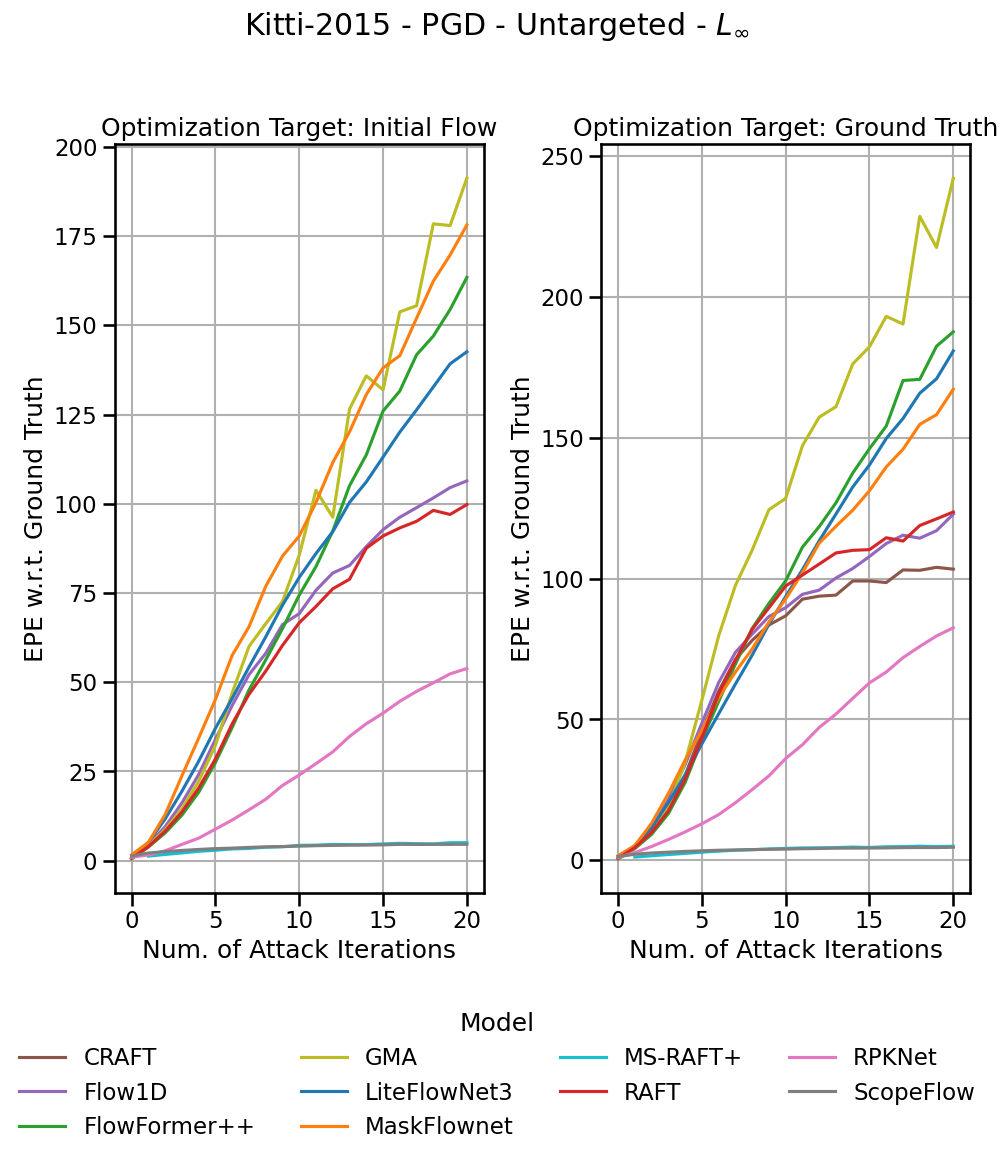

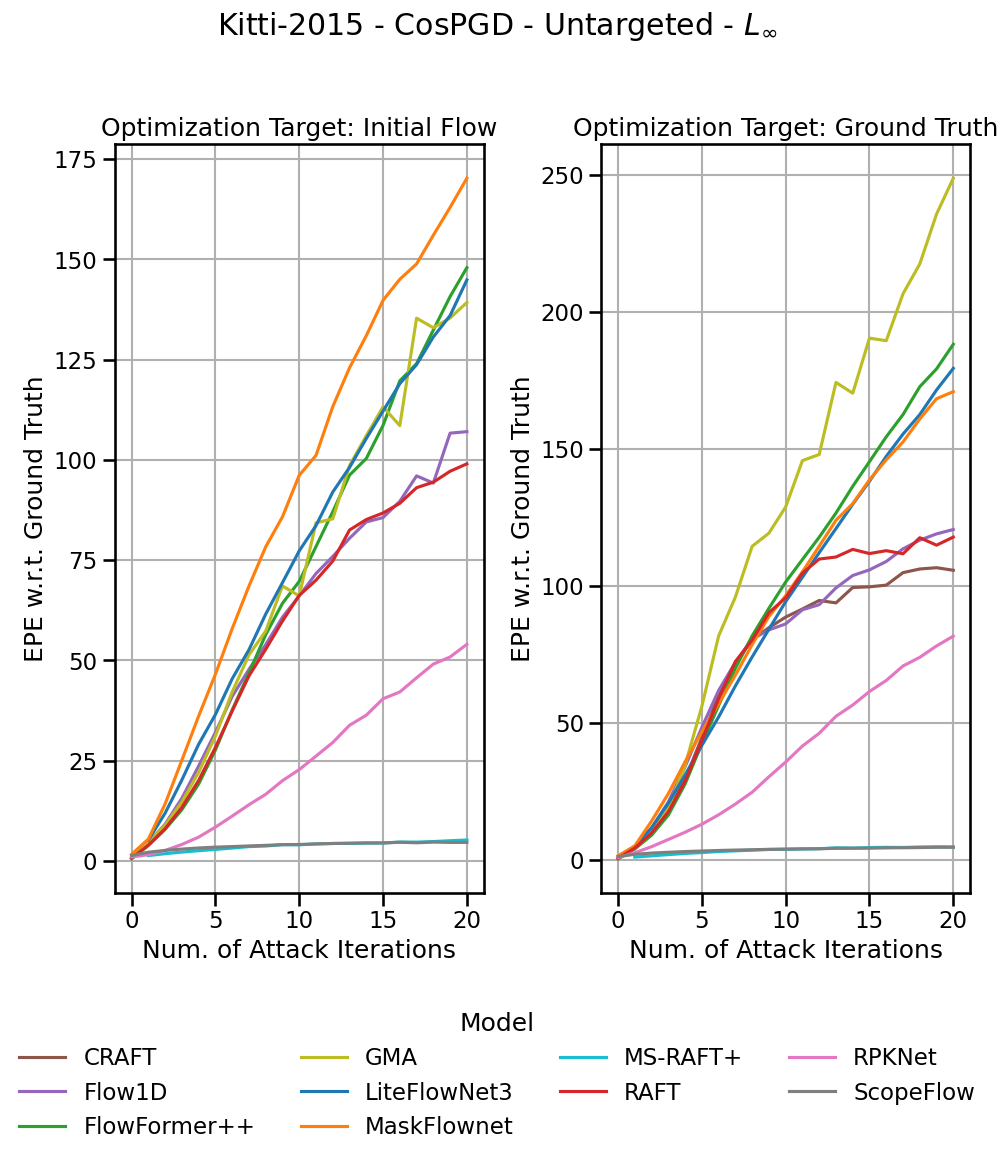

In [42]:


colors = plt.get_cmap("tab10").colors

# Create a distinct color palette for each model
model_palette_sintel_top10 = {model: color for model, color in zip(model_list_sintel_top10, colors)}
model_palette_kitti_top10 ={model: color for model, color in zip(model_list_kitti_top10, colors)}


def plot(data, title, filename, optim_targets):
    num_optim_target = len(optim_targets)
    fig, axes = plt.subplots(1, num_optim_target, figsize=(5 * num_optim_target, 10))
    fig.suptitle(title)

    if num_optim_target == 1:
        axes = [axes]

    # Collect handles and labels for the legend
    handles, labels = [], []

    for ax, optim_target in zip(axes, optim_targets):
        # Filter the data for the current optimization target
        plot_data = data.query(f"optim == '{optim_target}' or epsilon == 0")
        
        # Create a color palette using the color_map, matching models to their colors
        palette = {model: color_map.get(model, 'black') for model in plot_data['model'].unique()}

        # Create the line plot with consistent color mapping
        sns.lineplot(
            data=plot_data,
            x='iterations_type',
            y='epes',
            hue='model',
            palette=palette,  # Apply the color map to each model
            ax=ax,
            errorbar=None
        )

        # Collect legend handles and labels from each plot
        h, l = ax.get_legend_handles_labels()
        handles.extend(h)
        # Map the raw model names to their pretty names
        labels.extend([model_names_mapping.get(label, label) for label in l])

        ax.set_title(f"Optimization Target: {optim_target.replace('ground_truth', 'Ground Truth').replace('initial_flow', 'Initial Flow')}")
        ax.set_xlabel('Num. of Attack Iterations')
        ax.set_ylabel('EPE w.r.t. Ground Truth')
        ax.grid(True)

    # Remove individual legends from each subplot
    for ax in axes:
        ax.legend_.remove()

    # Create a unique legend for the entire figure using the mapped labels
    unique_handles_labels = dict(zip(labels, handles))
    fig.legend(unique_handles_labels.values(), unique_handles_labels.keys(), loc='upper center', bbox_to_anchor=(0.5, -0.001), ncol=4, frameon=False, title='Model')

    # Adjust layout to fit title and legend
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()

def transform_data(df, model_list, query, wrt):
    filtered_df = df.query(query + " or (attack == 'none' and dataset == 'kitti-2015' and model in @model_list)")
    # Reshape the data
    melted_df = filtered_df.melt(id_vars=['model', 'epsilon', 'attack', 'optim'], value_vars=[f'epe_{wrt}_i{i}' for i in range(0, 21)], var_name='iterations_type', value_name='epes')
    melted_df['iterations_type'] = melted_df['iterations_type'].str.extract('(\d+)').astype(int)
    return melted_df


### PGD ###

# Plot for untargeted attack
query = "attack == 'pgd' and norm == 'inf' and targeted == False and dataset == 'kitti-2015' and (checkpoint == 'kitti' or checkpoint == 'mixed') and epsilon == 0.0314 and model in @model_list"
data_untargeted_inf = transform_data(df, model_list_kitti_top10, query, wrt="gt")
plot(data_untargeted_inf, r'Kitti-2015 - PGD - Untargeted - $L_{\infty}$', 'graphs/PGD_kitti_init_flow.png', ["initial_flow", "ground_truth"])


### CosPGD ###

# Plot for untargeted attack
query = "attack == 'cospgd' and norm == 'inf' and targeted == False and dataset == 'kitti-2015' and (checkpoint == 'kitti' or checkpoint == 'mixed') and epsilon == 0.0314 and model in @model_list"
data_untargeted_inf = transform_data(df, model_list_kitti_top10, query, wrt="gt")
plot(data_untargeted_inf, r'Kitti-2015 - CosPGD - Untargeted - $L_{\infty}$', 'graphs/CosPGD_kitti_init_flow.png', ["initial_flow", "ground_truth"])


#### BIM/PGD/CosPGD init flow as optimization target -- Sintel-clean

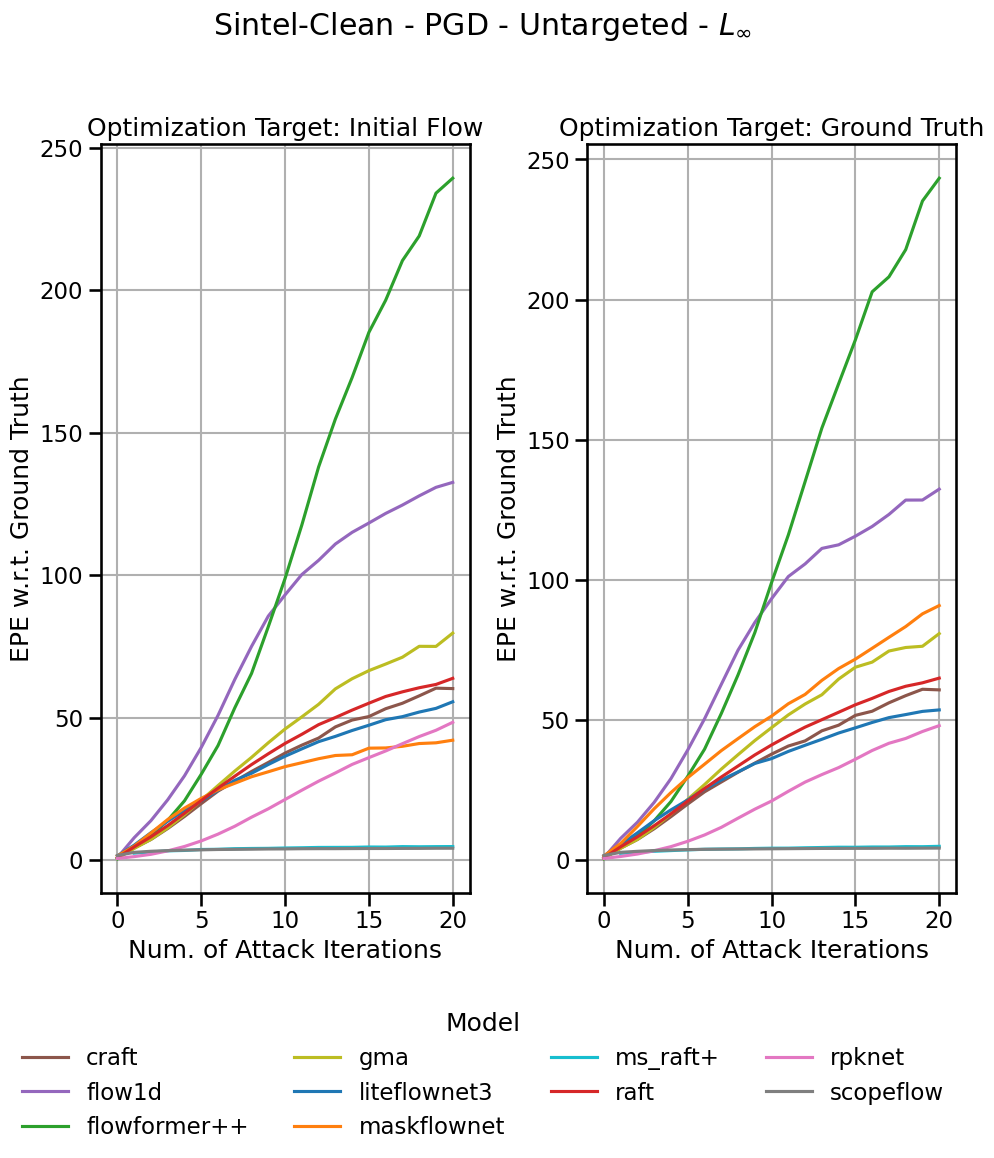

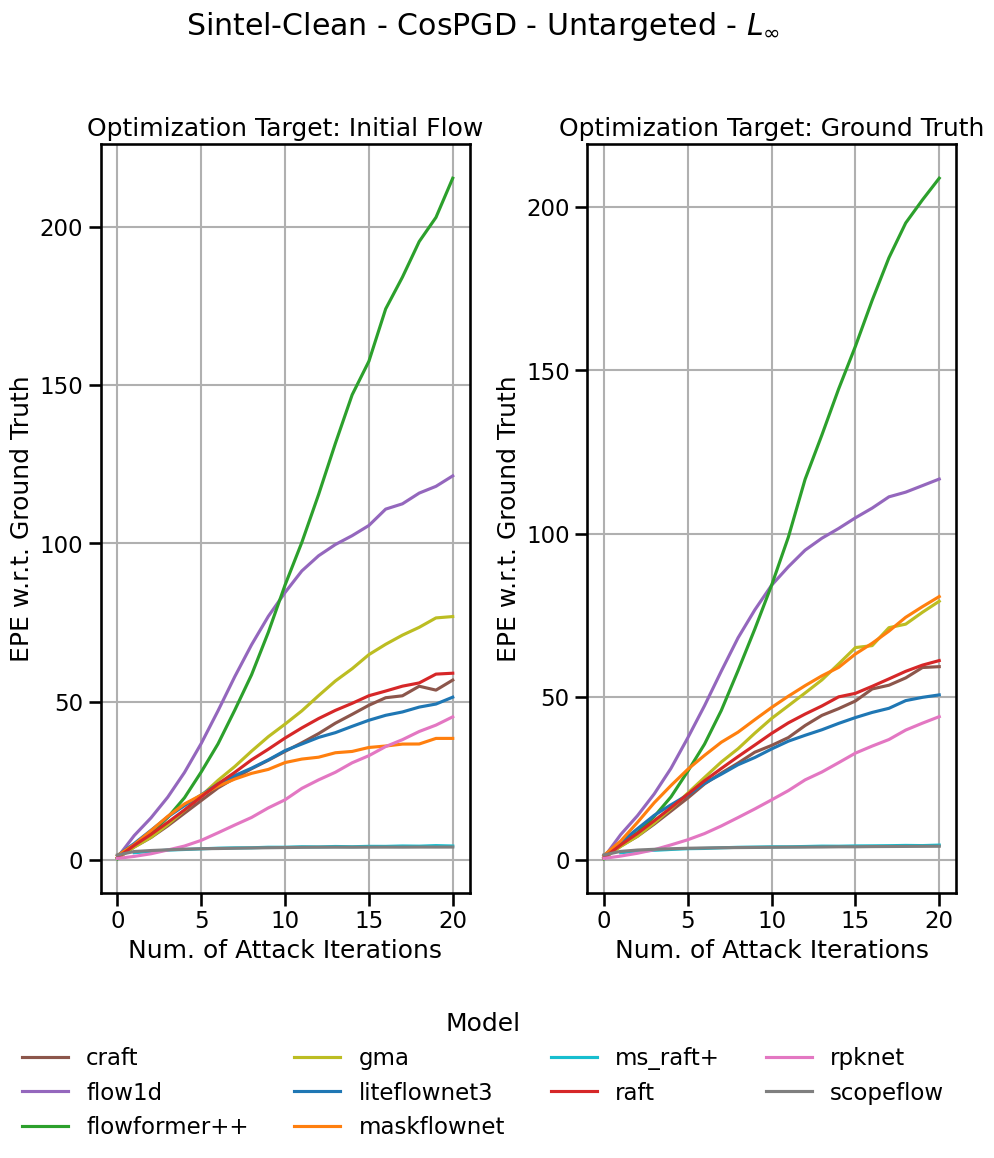

In [48]:
def transform_data(df, model_list, query, wrt):
    filtered_df = df.query(query + " or (attack == 'none' and dataset == 'sintel-clean' and model in @model_list)")
    # Reshape the data
    melted_df = filtered_df.melt(id_vars=['model', 'epsilon', 'attack', 'optim'], value_vars=[f'epe_{wrt}_i{i}' for i in range(0, 21)], var_name='iterations_type', value_name='epes')
    melted_df['iterations_type'] = melted_df['iterations_type'].str.extract('(\d+)').astype(int)
    return melted_df


### PGD ###

# Plot for untargeted attack
query = "attack == 'pgd' and norm == 'inf' and targeted == False and dataset == 'sintel-clean' and (checkpoint == 'sintel' or checkpoint == 'mixed') and epsilon == 0.0314 and model in @model_list"
data_untargeted_inf = transform_data(df, model_list_sintel_top10, query, wrt="gt")
plot(data_untargeted_inf, r'Sintel-Clean - PGD - Untargeted - $L_{\infty}$', 'graphs/PGD_sintel_clean_init_flow.png', ["initial_flow", "ground_truth"], model_palette_sintel_top10)


### CosPGD ###

# Plot for untargeted attack
query = "attack == 'cospgd' and norm == 'inf' and targeted == False and dataset == 'sintel-clean' and (checkpoint == 'sintel' or checkpoint == 'mixed') and epsilon == 0.0314 and model in @model_list"
data_untargeted_inf = transform_data(df, model_list_sintel_top10, query, wrt="gt")
plot(data_untargeted_inf, r'Sintel-Clean - CosPGD - Untargeted - $L_{\infty}$', 'graphs/CosPGD_sintel_clean_init_flow.png', ["initial_flow", "ground_truth"], model_palette_sintel_top10)


#### BIM/PGD/CosPGD init flow as optimization target -- Sintel-final

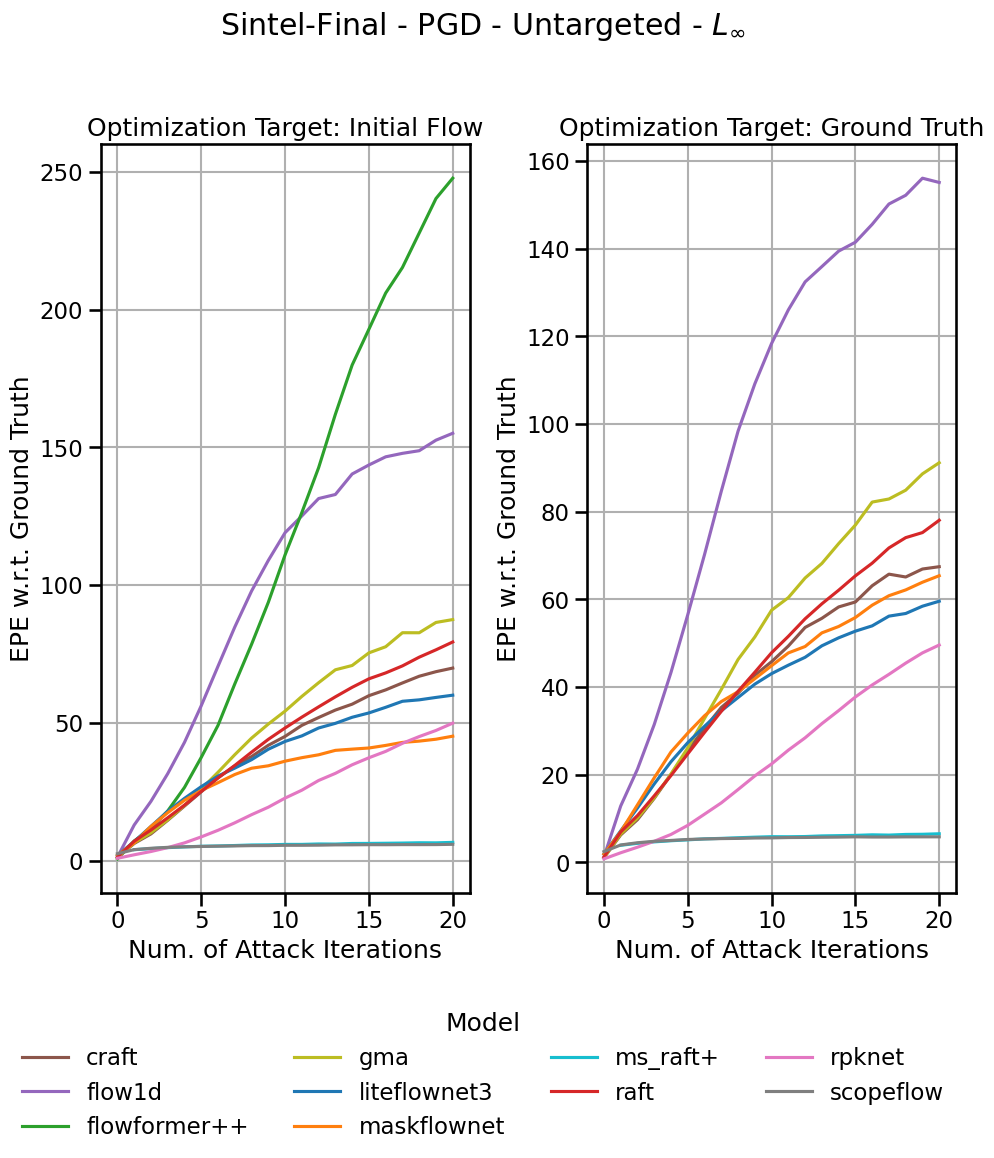

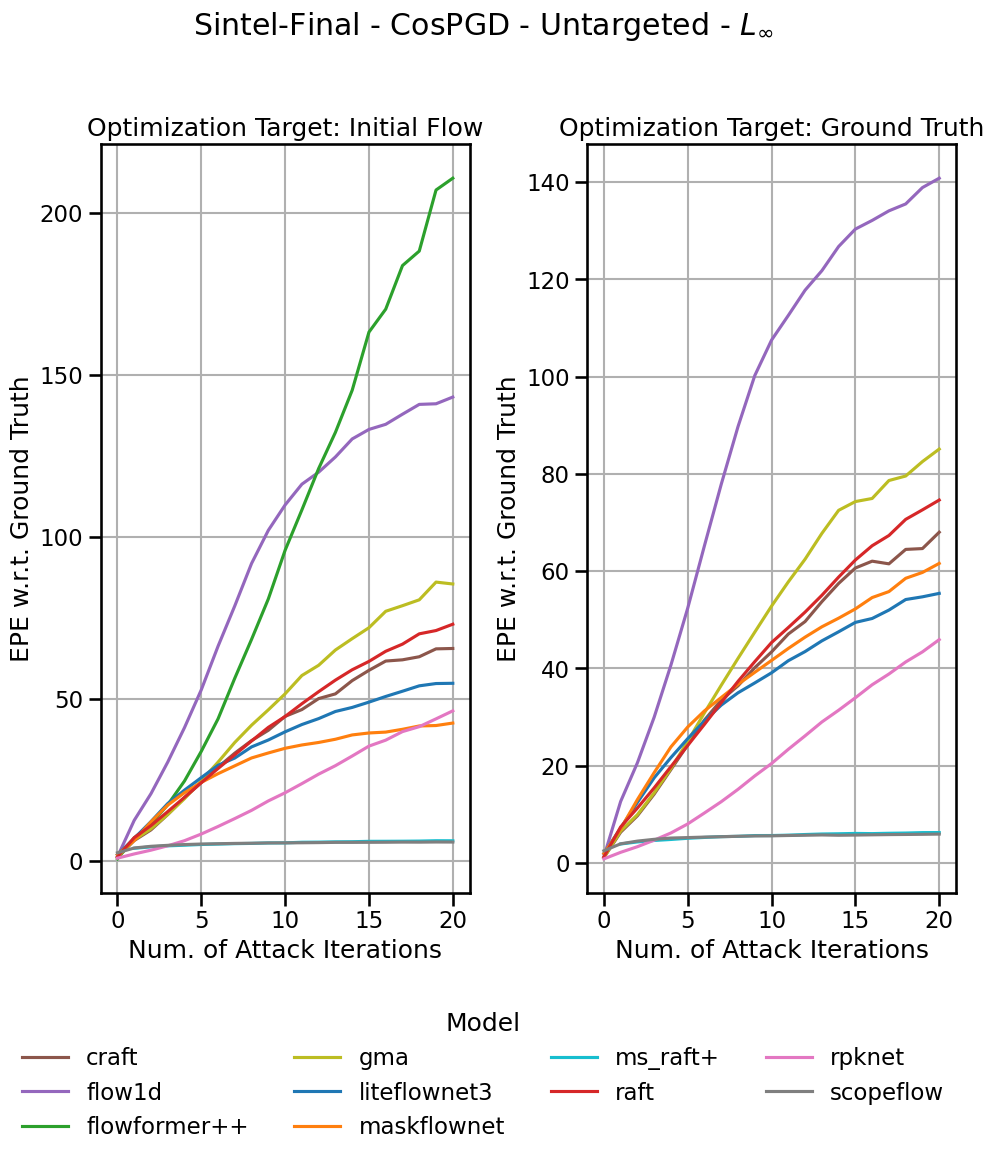

In [49]:
def transform_data(df, model_list, query, wrt):
    filtered_df = df.query(query + " or (attack == 'none' and dataset == 'sintel-final' and model in @model_list)")
    # Reshape the data
    melted_df = filtered_df.melt(id_vars=['model', 'epsilon', 'attack', 'optim'], value_vars=[f'epe_{wrt}_i{i}' for i in range(0, 21)], var_name='iterations_type', value_name='epes')
    melted_df['iterations_type'] = melted_df['iterations_type'].str.extract('(\d+)').astype(int)
    return melted_df

### PGD ###

# Plot for untargeted attack
query = "attack == 'pgd' and norm == 'inf' and targeted == False and dataset == 'sintel-final' and (checkpoint == 'sintel' or checkpoint == 'mixed') and epsilon == 0.0314 and model in @model_list"
data_untargeted_inf = transform_data(df, model_list_sintel_top10, query, wrt="gt")
plot(data_untargeted_inf, r'Sintel-Final - PGD - Untargeted - $L_{\infty}$', 'graphs/PGD_sintel_final_init_flow.png', ["initial_flow", "ground_truth"], model_palette_sintel_top10)


### CosPGD ###

# Plot for untargeted attack
query = "attack == 'cospgd' and norm == 'inf' and targeted == False and dataset == 'sintel-final' and (checkpoint == 'sintel' or checkpoint == 'mixed') and epsilon == 0.0314 and model in @model_list"
data_untargeted_inf = transform_data(df, model_list_sintel_top10, query, wrt="gt")
plot(data_untargeted_inf, r'Sintel-Final - CosPGD - Untargeted - $L_{\infty}$', 'graphs/CosPGD_sintel_final_init_flow.png', ["initial_flow", "ground_truth"], model_palette_sintel_top10)


### FGSM All Models


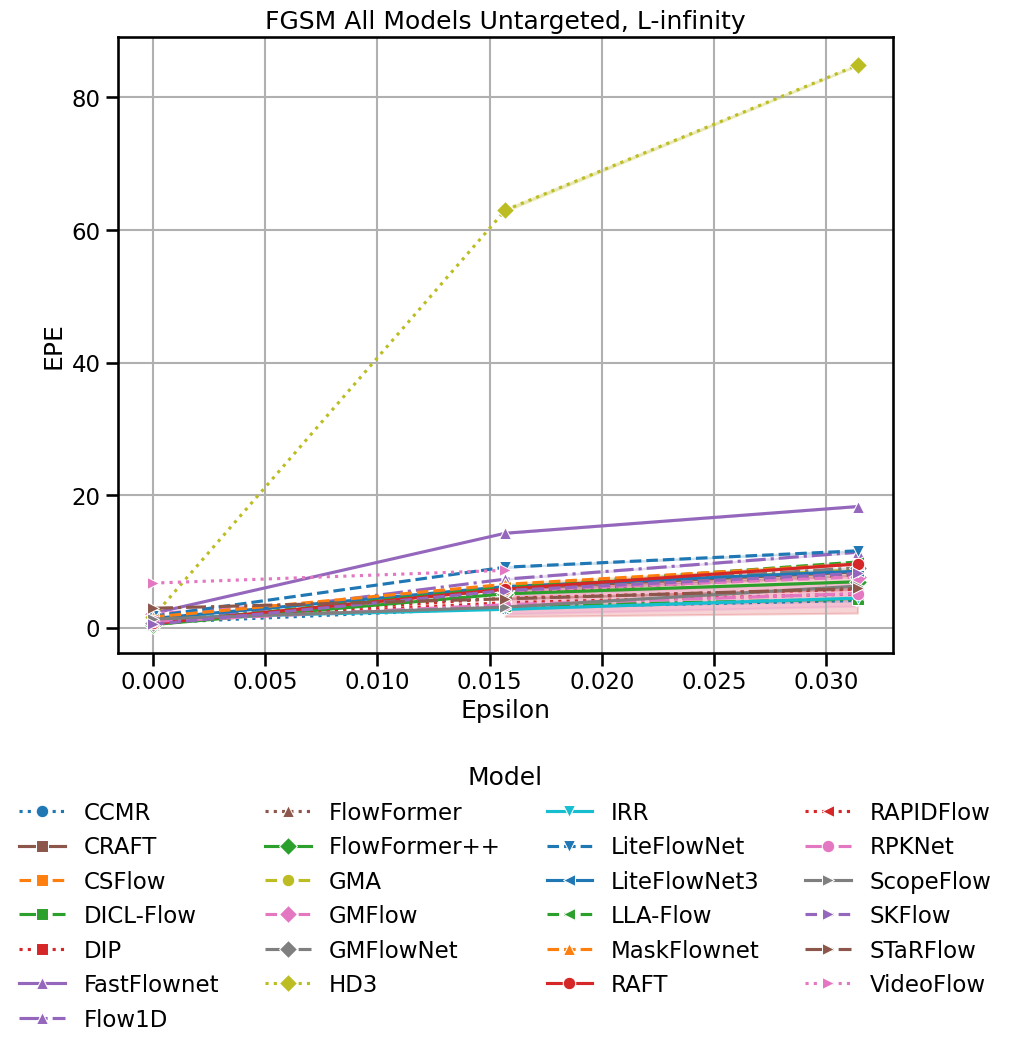

/scratch/ipykernel_1309287/4116817756.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['pretty_model_name'] = data['model'].apply(lambda x: model_names_mapping.get(x, x))
/scratch/ipykernel_1309287/4116817756.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['model_position'] = data['pretty_model_name'].map(model_mapping)
/scratch/ipykernel_1309287/4116817756.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_ind

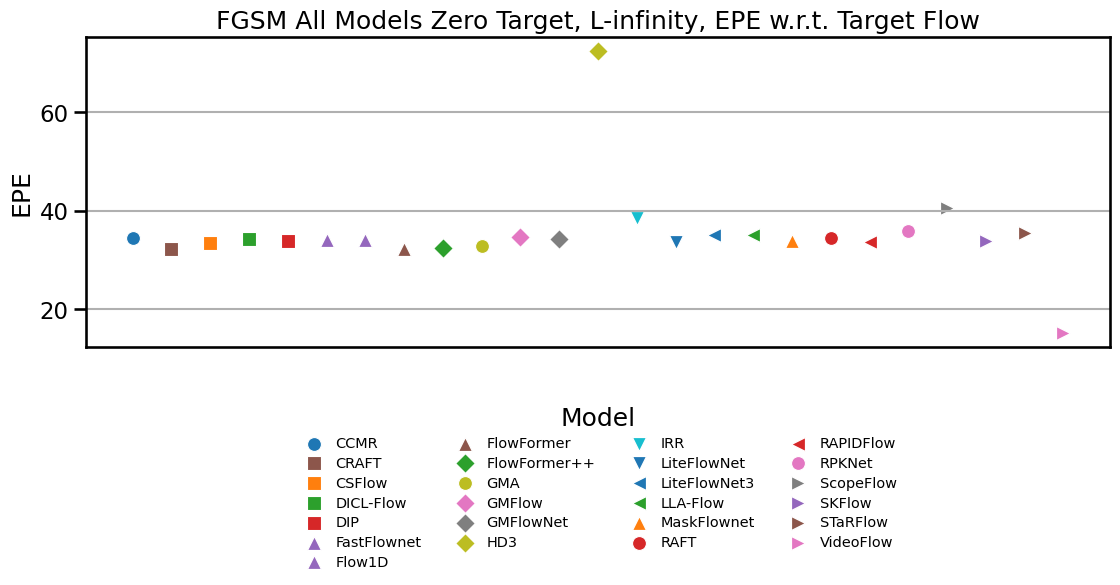

/scratch/ipykernel_1309287/4116817756.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['pretty_model_name'] = data['model'].apply(lambda x: model_names_mapping.get(x, x))
/scratch/ipykernel_1309287/4116817756.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['model_position'] = data['pretty_model_name'].map(model_mapping)
/scratch/ipykernel_1309287/4116817756.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_ind

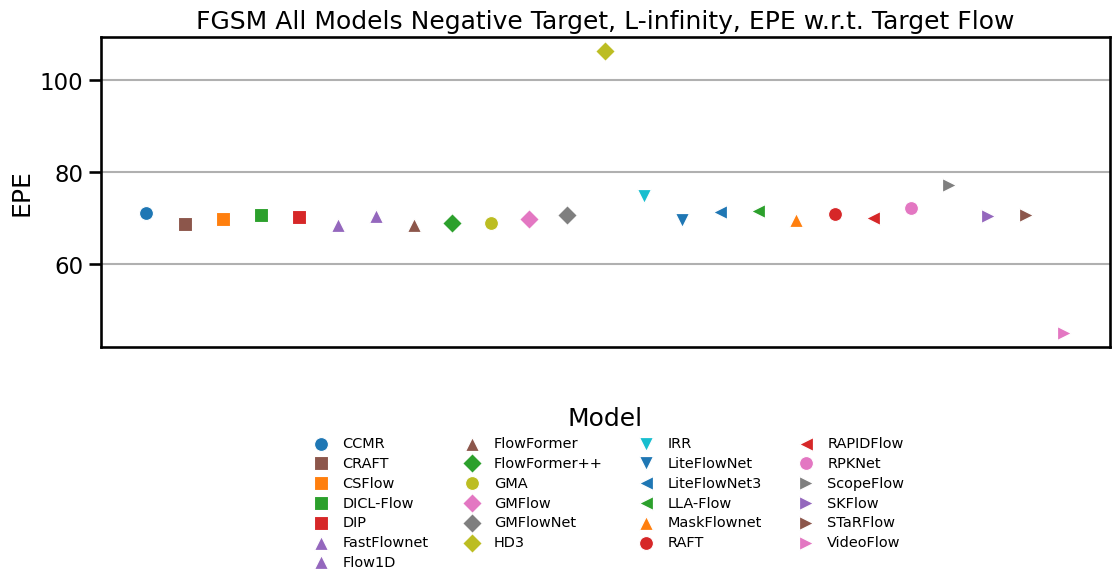

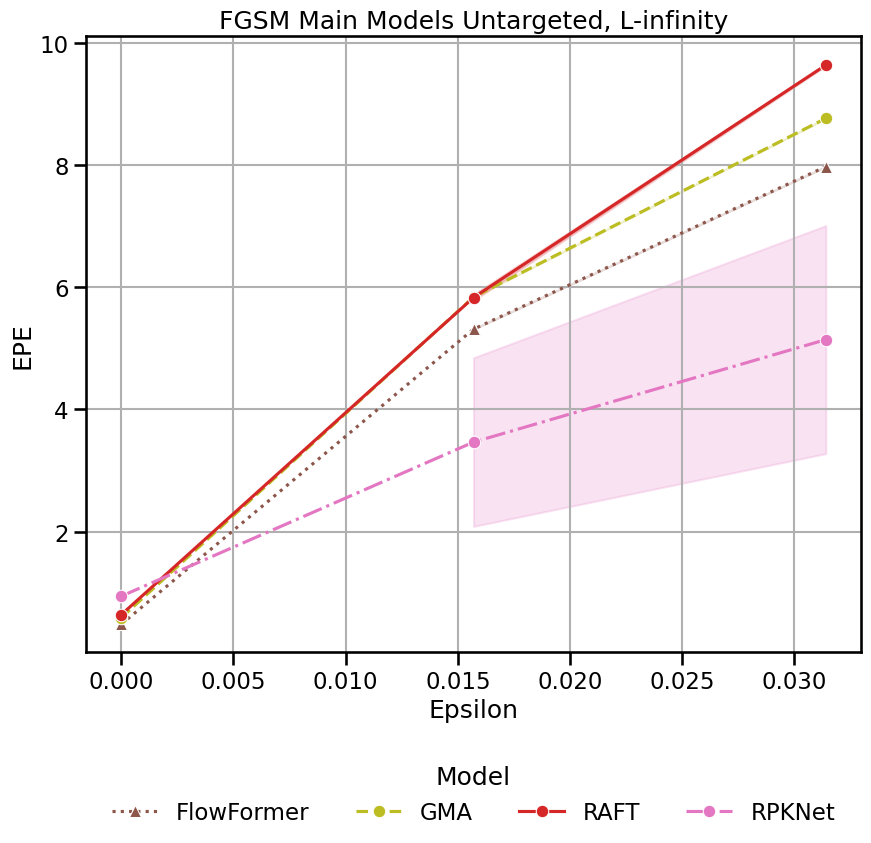

/scratch/ipykernel_1309287/4116817756.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['pretty_model_name'] = data['model'].apply(lambda x: model_names_mapping.get(x, x))
/scratch/ipykernel_1309287/4116817756.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['model_position'] = data['pretty_model_name'].map(model_mapping)
/scratch/ipykernel_1309287/4116817756.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_ind

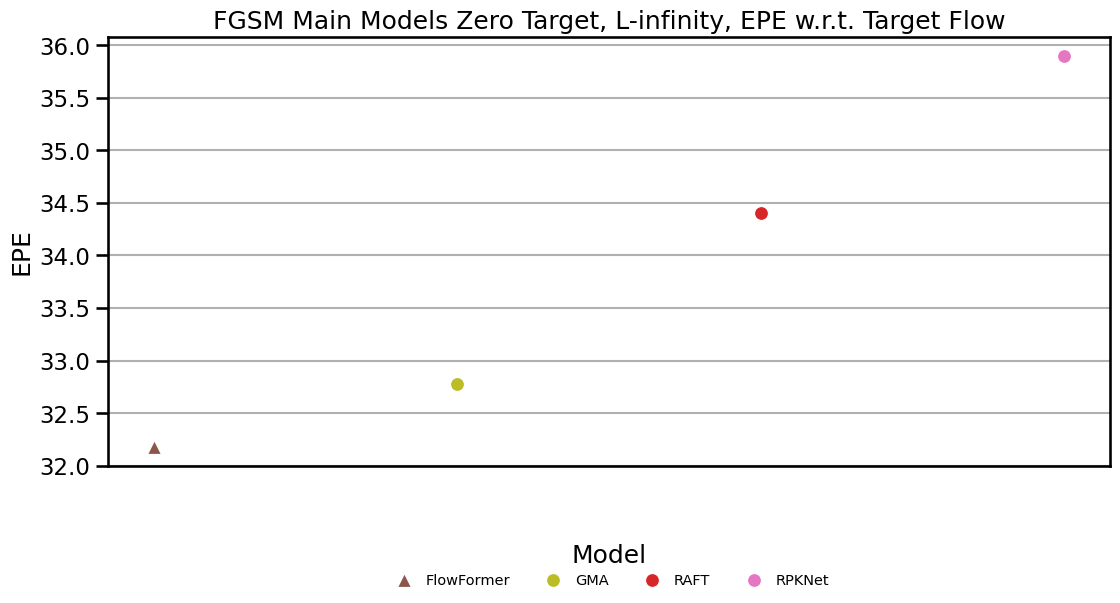

/scratch/ipykernel_1309287/4116817756.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['pretty_model_name'] = data['model'].apply(lambda x: model_names_mapping.get(x, x))
/scratch/ipykernel_1309287/4116817756.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['model_position'] = data['pretty_model_name'].map(model_mapping)
/scratch/ipykernel_1309287/4116817756.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_ind

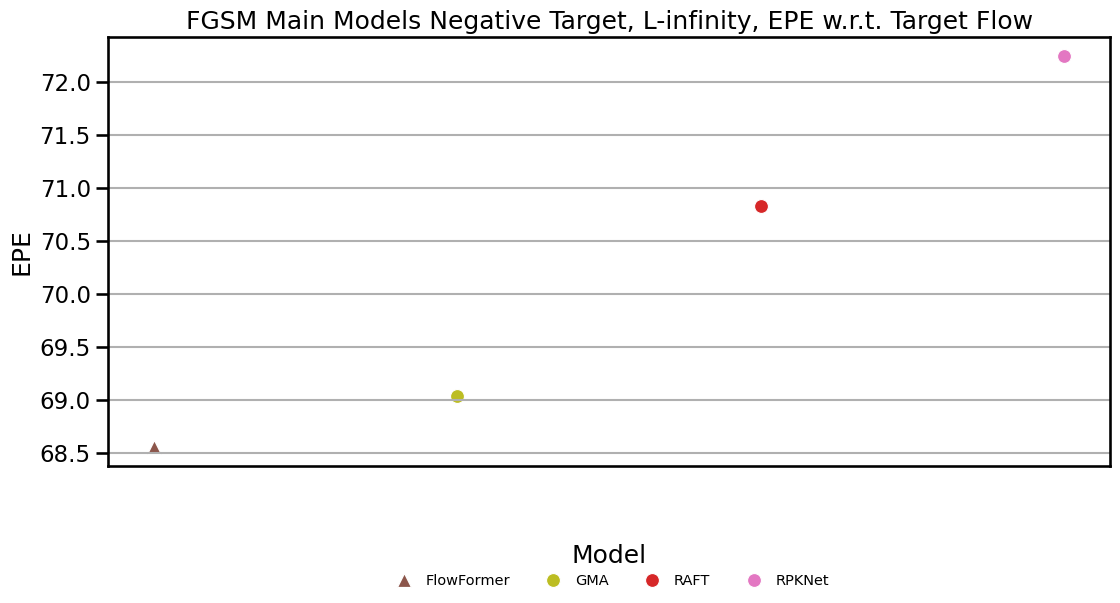

In [44]:
def plot_fgsm(data, title, filename):
    # Create the plot with additional styles for lines and markers
    plt.figure(figsize=(10, 8))

    # Iterate over models and plot each individually with custom markers, line styles, and colors
    for model in data['model'].unique():
        model_data = data[data['model'] == model]
        
        # Use the model names mapping for pretty names and apply the marker, line styles, and colors
        pretty_model_name = model_names_mapping.get(model, model)
        marker = marker_styles.get(model, 'o')  # Default to 'o' if no marker specified
        linestyle = line_styles.get(model, '-')  # Default to solid line if no linestyle specified
        color = color_map.get(model)  # Get color from the color map

        sns.lineplot(
            data=model_data,
            x='epsilon',
            y='epe',
            label=pretty_model_name,
            marker=marker,
            linestyle=linestyle,
            color=color  # Apply custom color for each model
        )

    # Customize the plot
    plt.xlabel('Epsilon')
    plt.ylabel('EPE')
    plt.grid(True)
    plt.title(title)

    # Remove annotations (previously added with plt.text)

    # Adjust legend
    plt.legend(title='Model', bbox_to_anchor=(0.5, -0.15), loc='upper center', ncol=4, frameon=False)

    # Show and save the plot
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()



def plot_fgsm_scatter(data, title, filename):
    # Increase figure size
    plt.figure(figsize=(12, 7))  # Adjust the figure size to increase the plot area

    # Replace model names with pretty names
    data['pretty_model_name'] = data['model'].apply(lambda x: model_names_mapping.get(x, x))

    # Create a numerical mapping for the model names
    model_mapping = {model: idx for idx, model in enumerate(data['pretty_model_name'].unique())}
    data['model_position'] = data['pretty_model_name'].map(model_mapping)

    # Apply marker styles based on the model
    data['marker'] = data['model'].apply(lambda x: marker_styles.get(x, 'o'))  # Default marker is 'o'

    # Create the scatter plot manually to apply custom markers and colors
    for model in data['model'].unique():
        model_data = data[data['model'] == model]
        pretty_model_name = model_names_mapping.get(model, model)
        marker = marker_styles.get(model, 'o')  # Get marker for the model
        color = color_map.get(model)  # Get color from the color map

        sns.scatterplot(
            data=model_data, 
            x='model_position', 
            y='epe', 
            label=pretty_model_name, 
            marker=marker,           # Apply custom marker for each model
            color=color,             # Apply custom color for each model
            s=100                    # Marker size
        )

    # Remove the x-axis labels (bottom model names)
    plt.gca().axes.get_xaxis().set_visible(False)

    # Customize the plot
    plt.ylabel('EPE')
    plt.grid(True, axis='y')
    plt.title(title)

    # Scale down the legend font size
    plt.legend(
        title='Model', 
        bbox_to_anchor=(0.5, -0.15), 
        loc='upper center', 
        ncol=4, 
        frameon=False, 
        fontsize='xx-small',      # Decreased font size
        handletextpad=0.5,        # Reduce spacing between the legend icon and text
        labelspacing=0.4          # Reduce vertical space between legend entries
    )

    # Save the plot with reduced padding
    plt.tight_layout(pad=2)
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()
# Plot for untargeted attack
data_untargeted = df.query("attack == 'fgsm' and norm == 'inf' and targeted == False and dataset == 'kitti-2015' and checkpoint == 'kitti' or (attack == 'none' and checkpoint == 'kitti')")
plot_fgsm(data_untargeted, "FGSM All Models Untargeted, L-infinity", 'graphs/FGSM All Models Untargeted INF.png')

# Plot for targeted attack with target zero
data_target_zero = df.query("attack == 'fgsm' and norm == 'inf' and targeted == True and target == 'zero' and dataset == 'kitti-2015' and checkpoint == 'kitti'")
plot_fgsm_scatter(data_target_zero, "FGSM All Models Zero Target, L-infinity, EPE w.r.t. Target Flow", 'graphs/FGSM All Models Zero Target INF.png')

# Plot for targeted attack with negative target
data_target_negative = df.query("attack == 'fgsm' and norm == 'inf' and targeted == True and target == 'negative' and dataset == 'kitti-2015' and checkpoint == 'kitti'")
plot_fgsm_scatter(data_target_negative, "FGSM All Models Negative Target, L-infinity, EPE w.r.t. Target Flow", 'graphs/FGSM All Models Negative Target INF.png')

specific_models = ['raft', 'pwcnet', 'gma', 'flownet2', 'flowformer', 'rpknet']

# Plot for untargeted attack with specific models
data_specific_models_untargeted = data_untargeted[data_untargeted['model'].isin(specific_models)]
plot_fgsm(data_specific_models_untargeted, "FGSM Main Models Untargeted, L-infinity", 'graphs/FGSM Main Models Untargeted INF.png')

# Plot for targeted attack with target zero and specific models
data_specific_models_target_zero = data_target_zero[data_target_zero['model'].isin(specific_models)]
plot_fgsm_scatter(data_specific_models_target_zero, "FGSM Main Models Zero Target, L-infinity, EPE w.r.t. Target Flow", 'graphs/FGSM Main Models Zero Target INF.png')

# Plot for targeted attack with negative target and specific models
data_specific_models_target_negative = data_target_negative[data_target_negative['model'].isin(specific_models)]
plot_fgsm_scatter(data_specific_models_target_negative, "FGSM Main Models Negative Target, L-infinity, EPE w.r.t. Target Flow", 'graphs/FGSM Main Models Negative Target INF.png')